In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#**Text to PostgreQL**

Vector Store: We have embedded the table metadata information in the PGVector.
Notebook: https://colab.sandbox.google.com/drive/1J343b9puOH1VbvDZdQ0HioTDF6ikYmKK#scrollTo=os2Vcdvi9EHH

Here is the logic used for embedding
1. Table metadata
2. Column details with type and description
3. Known examples for few-shots

Possible implementations:

1. Using text-bison: Current Notebook

   **Status:** <WIP>  
   **Inference:** <WIP>
   **Problem:** <TBU>

2. Text embedding using LangChain and Vector store:
  **Status:** Planned
  **Idea:** To embed and example schema with the same prompt/SQLs

------
**Current Implementation:** This notebook conatins the text-bison based prompt design for generating the Postgre SQL from the provided Natural-language command.


  **Prompt design:**
  We have refered to the prompt design mentioned in one of Google Paper i.e: https://github.com/doitintl/next23-genai-demo/blob/main/vertex-code-bison-text-to-sql.ipynb

  Idea is to extarct the required database schema and convert it to a readable text.

**Architecture design**

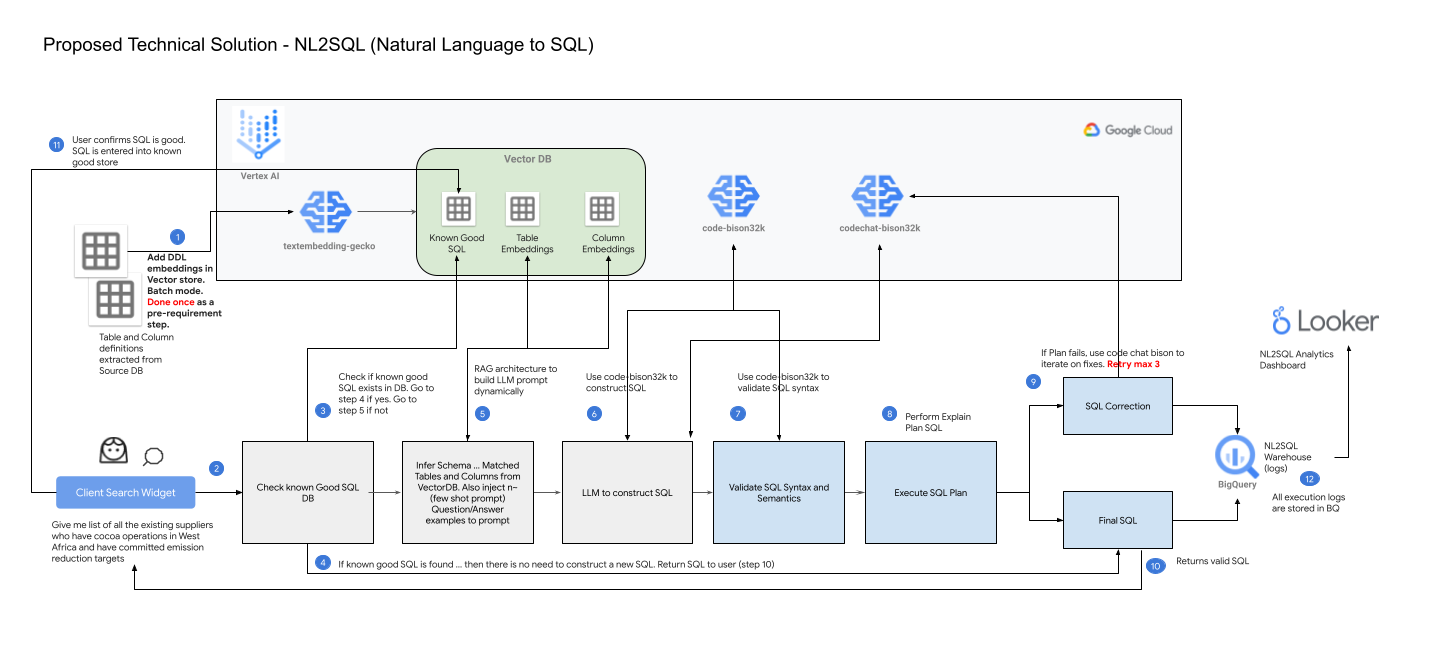


  Below is the example prompt mentioned from the Google Paper:

  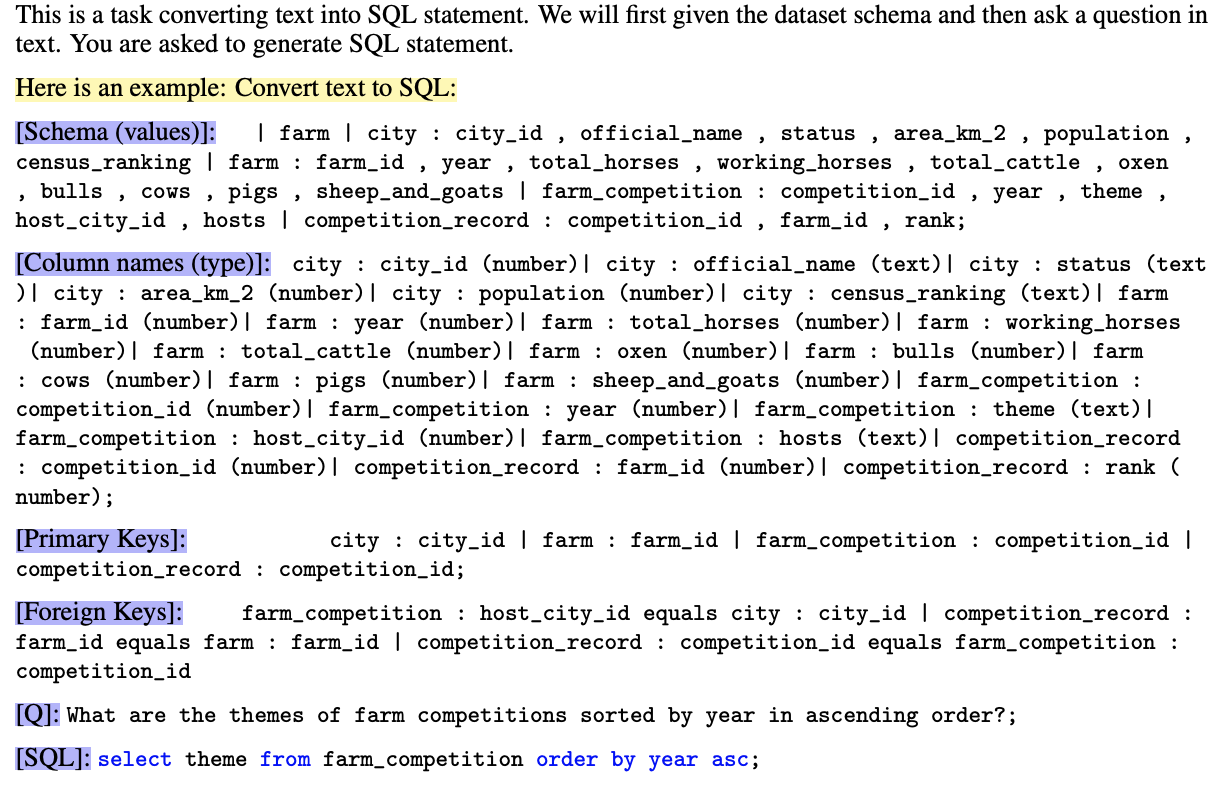





Test Dataset: bigquery-public-data.imdb from BQ


##Prompt

Below is the prompt being used
Where
database_metadata: Details the combination of given database, table and columns  
table_metadata: Details the combination of given table and columns (with datatype and comments)

```
 You are an PostgreSQL SQL guru. Write a SQL comformant query for PostgreSQL that answers the following question while using the provided context to correctly refer to postgres tables and the needed column names.

    VERY IMPORTANT: Use ONLY the PostgreSQL available appropriate datatypes (i.e {pg_specific_data_types}) while casting the column in the SQL.
    IMPORTANT: In "FROM" and "JOIN" blocks always refer the table_name as schema.table_name.
    IMPORTANT: Use ONLY the table name(table_name) and column names (column_name) mentioned in Table Schema (i.e {tables_schema}). DO NOT USE any other column names outside of this.
    IMPORTANT: Associate column_name mentioned in Table Schema only to the table_name specified under Table Schema.
    NOTE: Use SQL 'AS' statement to assign a new name temporarily to a table column or even a table wherever needed.

    Guidelines:
    - Join as minimal tables as possible.
    - When joining tables ensure all join columns are the same data_type.
    - Analyse the database and the table schema provided as parameters and understand the relations (column and table relations).
    - Don't include any comments in code.
    - Remove ```sql and ``` from the output and generate the SQL in single line.
    - Tables should be refered to using a fully qualified name including owner and table name.
    - Use table_alias.column_name when referring to columns. Example: dept_id=hr.dept_id
    - Capitalize the table names on SQL "where" condition.
    - Use the columns from the "SELECT" statement while framing "GROUP BY" block.
    - Always refer the column-name with rightly mapped table-name as seen in the table schema.
    - Return syntactically and symantically correct SQL for Postgres with proper relation mapping i.e owner, table and column relation.
    - Refer to the examples provided i.e. {similar_sql}


  Here are some examples of user-question and SQL queries:
  {similar_sql}


  question:
  {user_question}

  Table Schema:
  {tables_schema}

  Column Description:
  {tables_detailed_schema}

```

## **Installing all the required dependencies**

[Requires cleanup]

In [ ]:
first = True
if first:
  ! pip install google-cloud-aiplatform --upgrade
  # ! pip install shapely==1.8.5
  ! pip install "cloud-sql-python-connector[pg8000]"
  # Install dependencies.
  !pip install asyncio asyncpg cloud-sql-python-connector["asyncpg"]
  !pip install numpy --upgrade
  !pip install pandas
  !pip install pgvector
  !pip install langchain transformers

In [ ]:
# @markdown Replace the required placeholder text below. You can modify any other default values, if you like.

# Please fill in these values.
source_type = "postgres" # @param {type:"string"}
project_id = "steveswalker-sandbox"  # @param {type:"string"}
database_password = "text2sql-demo-pg"  # @param {type:"string"}
region = "us-central1"  # @param {type:"string"}
instance_name = "text2sql-demo-pg"  # @param {type:"string"}
database_name = "nl2sql_test"  # @param {type:"string"}
database_user = "postgres"  # @param {type:"string"}
pg_schema = "ukg_test"  # @param {type:"string"}

# BQ_PROJECT = "retail"  # @param {type:"string"}
BQ_DATASET = "nl2sql_log"  # @param {type:"string"}
ENABLE_ANALYTICS = True # @param {type:"string"}
DATASET_LOCATION = 'us-central1' # @param {type:"string"}
EXECUTE_FINAL_SQL = True # @param {type:"boolean"}

model_id = "text-bison-32k"  # @param {type:"string"}
LOG_TABLE_NAME = "nl2sql_for_pg"  # @param {type:"string"}
embeddings_model='textembedding-gecko@001' # @param {type:"string"}
# Quick input validations.
assert project_id, "⚠️ Please provide a Google Cloud project ID"
assert region, "⚠️ Please provide a Google Cloud region"
assert instance_name, "⚠️ Please provide the name of your instance"
assert database_name, "⚠️ Please provide a database name"
assert database_user, "⚠️ Please provide a database user"
assert database_password, "⚠️ Please provide a database password"
assert pg_schema, "⚠️ Please provide a PG schema"

## **Importing all the required libraries** [Needs further clean-up]

In [ ]:
from langchain.embeddings import VertexAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from vertexai.language_models import TextEmbeddingModel
from google.cloud import aiplatform
from pgvector.asyncpg import register_vector
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector
from google.cloud.exceptions import NotFound
# Generate the vector embeddings for each chunk of text.
# This code snippet may run for a few minutes.
from google.cloud import bigquery
from langchain.embeddings import VertexAIEmbeddings
from google.cloud import aiplatform
import time
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector
import numpy as np
from pgvector.asyncpg import register_vector
from datetime import datetime
import urllib
import json
import re
import time
import textwrap
import pandas as pd
import os
from google.cloud import storage
import io
import pandas as pd
from google.cloud import storage
from io import StringIO
from sqlalchemy import create_engine
from sqlalchemy.engine import Engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from google.cloud.sql.connector import Connector, IPTypes
from sqlalchemy.sql import text
from google.colab import data_table
import pandas_gbq
data_table.enable_dataframe_formatter()

agent = None

##Authenticate your Google Cloud Account and enable APIs.

In [ ]:
import os
auth_user=!gcloud config get-value account
auth_user=auth_user[0]
print('Authenticated User: ' + str(auth_user))

Authenticated User: sguruprasad@google.com


In [ ]:
#@markdown
import vertexai

# Authenticate gcloud.
from google.colab import auth
auth.authenticate_user()

# Configure gcloud.
!gcloud config set project {project_id}
!gcloud config get-value project
# #!bash gcloud auth application-default login
# # Grant Cloud SQL Client role to authenticated user
# current_user = !gcloud auth list --filter=status:ACTIVE --format="value(account)"

# !gcloud projects add-iam-policy-binding {project_id} \
#   --member=user:{current_user[0]} \
#   --role="roles/cloudsql.client"
vertexai.init(project=project_id, location=region)

SQL_VALIDATION='ALL'
INJECT_ONE_ERROR=False
EXECUTE_FINAL_SQL=True

# # Enable Cloud SQL Admin API
# !gcloud services enable sqladmin.googleapis.com
# !gcloud services enable aiplatform.googleapis.com

Updated property [core/project].
steveswalker-sandbox


In [ ]:
# Authenticate gcloud.
from google.colab import auth
auth.authenticate_user()

# Configure gcloud.
!gcloud config set project {project_id}

# # Grant Cloud SQL Client role to authenticated user
# current_user = !gcloud auth list --filter=status:ACTIVE --format="value(account)"

# !gcloud projects add-iam-policy-binding {project_id} \
#   --member=user:{current_user[0]} \
#   --role="roles/cloudsql.client"


# # Enable Cloud SQL Admin API
# !gcloud services enable sqladmin.googleapis.com
# !gcloud services enable aiplatform.googleapis.com

Updated property [core/project].


In [ ]:
from google.colab import auth
auth.authenticate_user()

## Resuable Utilities

In [ ]:


def text_embedding(question):
    """Text embedding with a Large Language Model."""
    model = TextEmbeddingModel.from_pretrained(embeddings_model)
    embeddings = model.get_embeddings([question])
    for embedding in embeddings:
        vector = embedding.values
        print(f"Length of Embedding Vector: {len(vector)}")
    return vector






## Enable NL2SQL Analytics Warehouse
If ENABLE_ANALYTICS is true, create a BQ Dataset to store a log of all SQL creations

In [ ]:
if ENABLE_ANALYTICS is True:
  # Create a BigQuery client
  bq_client = bigquery.Client(location=region, project=project_id)

  # Create a dataset
  try:
    dataset = bq_client.create_dataset(dataset=BQ_DATASET)
  except Exception as e:
    print('Failed to create the dataset\n')
    print(str(e))

Failed to create the dataset

409 POST https://bigquery.googleapis.com/bigquery/v2/projects/steveswalker-sandbox/datasets?prettyPrint=false: Already Exists: Dataset steveswalker-sandbox:nl2sql_log


In [ ]:
def append_2_bq(model, question, generated_sql, found_in_vector, need_rewrite, failure_step, error_msg):
  global FULL_LOG_TEXT

  if ENABLE_ANALYTICS is True:
      print('\nInside the Append to BQ block\n')
      table_id=project_id + '.' + BQ_DATASET + '.' + LOG_TABLE_NAME
      now = datetime.now()

      table_exists=False
      client = bigquery.Client()

      df1 = pd.DataFrame(columns=[
          'source_type',
          'project_id',
          'user',
          'schema',
          'model_used',
          'question',
          'generated_sql',
          'found_in_vector',
          'need_rewrite',
          'failure_step',
          'error_msg',
          'execution_time',
          'full_log'
          ])

      new_row = {
          "source_type":source_type,
          "project_id":str(project_id),
          "user":str(auth_user),
          "schema": pg_schema,
          "model_used": model,
          "question": question,
          "generated_sql": generated_sql,
          "found_in_vector":found_in_vector,
          "need_rewrite":need_rewrite,
          "failure_step":failure_step,
          "error_msg":error_msg,
          "execution_time": now,
          "full_log": FULL_LOG_TEXT
        }

      df1.loc[len(df1)] = new_row

      db_schema=[
            # Specify the type of columns whose type cannot be auto-detected. For
            # example the "title" column uses pandas dtype "object", so its
            # data type is ambiguous.
            bigquery.SchemaField("source_type", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("project_id", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("user", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("schema", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("model_used", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("question", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("generated_sql", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("found_in_vector", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("need_rewrite", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("failure_step", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("error_msg", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("execution_time", bigquery.enums.SqlTypeNames.TIMESTAMP),
            bigquery.SchemaField("full_log", bigquery.enums.SqlTypeNames.STRING),
          ]

      try:
        client.get_table(table_id)  # Make an API request.
        #print("Table {} already exists.".format(table_id))
        table_exists=True
      except NotFound:
          print("Table {} is not found.".format(table_id))
          table_exists=False

      if table_exists is True:
          print('Performing streaming insert')
          errors = client.insert_rows_from_dataframe(table=table_id, dataframe=df1, selected_fields=db_schema)  # Make an API request.
          #if errors == []:
          #    print("New rows have been added.")
          #else:
          #    print("Encountered errors while inserting rows: {}".format(errors))
      else:
          pandas_gbq.to_gbq(df1, table_id, project_id=project_id)  # replace to replace table; append to append to a table


      # df1.loc[len(df1)] = new_row
      # pandas_gbq.to_gbq(df1, table_id, project_id=project_id, if_exists='append')  # replace to replace table; append to append to a table
      print('\n Query added to BQ log table \n')
      FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Query added to BQ log table \n'
      return 'Row added'
  else:
    print('\n BQ Analytics is disabled so query was not added to BQ log table \n')
    FULL_LOG_TEXT= FULL_LOG_TEXT + '\n BQ Analytics is disabled so query was not added to BQ log table \n'

    return 'BQ Analytics is disabled'


### PostGre Util functions

In [ ]:
def cloudSQL_pg_create_df(query: str):


    # initialize Connector object
    connector = Connector()

    # function to return the database connection object
    def getconn():
        conn = connector.connect(
            "steveswalker-sandbox:us-central1:text2sql-demo-pg",
            "pg8000",
            user="postgres",
            password="text2sql-demo-pg",
            db="nl2sql_test"
        )
        return conn

    # create connection pool with 'creator' argument to our connection object function
    pool = create_engine(
        "postgresql+pg8000://",
        creator=getconn,
    )

    result_df=pd.DataFrame()
    query_new=f"""
    {query}

    """
    # connect to connection pool
    with pool.connect() as db_conn:
        # query and fetch ratings table
          df = pd.read_sql(text(query_new), con=db_conn)
          # con.close()
          result_df = df

    return result_df




Method for extracting the schema from PgVector tables

In [ ]:
async def getSchema(user_question,num_matches, tbl_similarity_threshold, col_similarity_threshold,pg_schema):
    # embedding_service = VertexAIEmbeddings()

    qe = text_embedding(user_question)
    matches = []
    matches_tbl = []
    matches_sql = []

    async def main():
        loop = asyncio.get_running_loop()
        async with Connector(loop=loop) as connector:
            # Create connection to Cloud SQL database.
            conn: asyncpg.Connection = await connector.connect_async(
                f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
                "asyncpg",
                user=f"{database_user}",
                password=f"{database_password}",
                db=f"{database_name}",
            )

            await register_vector(conn)
            # similarity_threshold = 0.7
            # num_matches = 10

            table_results = await conn.fetch(
                """
                                WITH vector_matches AS (
                                  SELECT table_name, table_schema, content,
                                  (embedding <=> $1) AS similarity
                                  FROM table_details_embeddings
                                  WHERE 1 - (embedding <=> $1) > $2
                                  LIMIT $3
                                )
                                SELECT string_agg(content,' | ') as schema_dt
                                FROM vector_matches
                                where table_schema = $4
                                group by table_name, table_schema
                                """,
                qe,
                tbl_similarity_threshold,
                10,
                pg_schema
            )
            if len(table_results) == 0:
              print("Did not find any results. Adjust the query parameters.")
            # else:
            #   print(results)

            table_name_txt = 'Schema(values):'
            for r in table_results:
                # Collect the description for all the matched table schema and will frame the schema
                # print(r["table_schema"])
                table_name_txt=table_name_txt+r["schema_dt"]+" | "
            matches_tbl.append(table_name_txt)

            # Find similar columns details to the query using cosine similarity search
            # over all vector embeddings. This new feature is provided by `pgvector`.
            column_results = await conn.fetch(
                """
                                WITH vector_matches AS (
                                  SELECT table_name, table_schema, content,
                                  (embedding <=> $1) AS similarity
                                  FROM tablecolumn_details_embeddings
                                  WHERE 1 - (embedding <=> $1) > $2
                                  LIMIT $3
                                )
                                SELECT content as table_schema_det
                                FROM vector_matches
                                where table_schema = $4
                                """,
                qe,
                col_similarity_threshold,
                20,
                pg_schema
            )

            if len(column_results) == 0:
              print("Did not find any results. Adjust the query parameters.")
            # else:
            #   print(results)

            table_column_txt = 'Column name(type):'
            for r in column_results:
                # Collect the description for all the matched table schema and will frame the schema
                # print(r["table_schema"])
                table_column_txt=table_column_txt+r["table_schema_det"]+" | "
            matches.append(table_column_txt)

            # Close the connection to the database.
            await conn.close()


    await main()  # type: ignore

    tables_schema=matches_tbl[0]
    # Show the results for similar products that matched the user query.
    tables_detailed_schema=matches[0]
    return tables_schema,tables_detailed_schema

Function for extracting the pre-read/created SQLs from PgVector tables

In [ ]:
async def getEmbeddedSQL(user_question, num_matches, similarity_threshold, pg_schema):
    # embedding_service = VertexAIEmbeddings()

    qe = text_embedding(user_question)
    matches = []
    matches_tbl = []
    matches_sql = []
    global sql_examples
    sql_examples=''

    async def main():
        loop = asyncio.get_running_loop()
        async with Connector(loop=loop) as connector:
            # Create connection to Cloud SQL database.
            conn: asyncpg.Connection = await connector.connect_async(
                f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
                "asyncpg",
                user=f"{database_user}",
                password=f"{database_password}",
                db=f"{database_name}",
            )

            await register_vector(conn)

            sql_example = await conn.fetch(
                """
                                WITH vector_matches AS (
                                  SELECT table_schema, example_user_question, example_generated_sql, content,
                                  (embedding <=> $1) AS similarity
                                  FROM example_prompt_sql_embeddings
                                  WHERE 1 - (embedding <=> $1) > $2
                                  LIMIT $3
                                )
                                SELECT example_user_question, example_generated_sql, string_agg(content,'') as schema_dt
                                FROM vector_matches
                                where table_schema = $4
                                group by example_user_question, example_generated_sql
                                """,
                qe,
                similarity_threshold,
                num_matches,
                pg_schema
            )
            print("sql_example: " + str(sql_example))
            if len(sql_example) == 0:
              print("Did not find any results. Adjust the query parameters.")
            # else:
            #   print(results)

            sql_example_txt = ''
            for r in sql_example:
              example_user_question=r["example_user_question"]
              example_sql=r["example_generated_sql"]
              sql_example_txt = sql_example_txt + "\n Example_question: "+example_user_question+ "; Example_SQL: "+example_sql

            matches_sql.append(sql_example_txt)

            # Close the connection to the database.
            await conn.close()


    await main()  # type: ignore
    print(sql_examples)
    if len(matches_sql) == 0:
      example_sql = None
    else:
      example_sql = matches_sql[0]


    return example_sql

### Reusable functions for using LLM models

Function for creating the LLM model

In [ ]:

def createModel(PROJECT_ID, REGION, model_id):
  from vertexai.preview.language_models import TextGenerationModel
  from vertexai.preview.language_models import CodeGenerationModel
  from vertexai.preview.language_models import CodeChatModel

  if model_id == 'code-bison-32k':
    model = CodeGenerationModel.from_pretrained('code-bison-32k')
  elif model_id == 'text-bison-32k':
    model = TextGenerationModel.from_pretrained('text-bison-32k')
  elif model_id == 'codechat-bison-32k':
    model = CodeChatModel.from_pretrained("codechat-bison-32k")
  else:
    raise ValueError
  return model

In [ ]:
# context_prompt = f"""

#     You are an POSTGRES SQL guru. Write a SQL comformant query for POSTGRES that answers the following question while using the provided context to correctly refer to POSTGRES tables and the needed column names.

#     IMPORTANT: Use the right schema names, table names and column names as mentioned in the Table Schema.
#     IMPORTANT: Use ONLY the column names (column_name) mentioned in Table Schema. DO NOT USE any other column names outside of this.
#     IMPORTANT: Use ONLY the POSTGRES supported datatypes while casting the column during SQL generating the SQL.
#     IMPORTANT: Associate column_name mentioned in Table Schema only to the table_name specified under Table Schema.
#     NOTE: Use SQL 'AS' statement to assign a new name temporarily to a table column or even a table wherever needed.

#     Guidelines:
#     - Join as minimal tables as possible.
#     - Use the fully qualified table name with Schema-name reference in the "FROM" block of the SQL using the Table Schema. i.e schema.table_name.
#     - Ensure to include all the tables required for the SQL in FROM or Join block.
#     - When joining tables ensure all join columns are the same data_type.
#     - Analyse the schema and the table details provided as parameters and undestand the relations (column and table relations).
#     - Don't include any comments in code.
#     - Remove ```sql and ``` from the output and generate the SQL in single line.
#     - Through out the SQL use table_alias.column_name when referring to columns. Example: dept_id=hr.dept_id
#     - Use the columns from the "SELECT" statement while framing "GROUP BY" block.
#     - Always refer the column name with rightly mapped table-name as seen in the Table Schema and Column Schema.
#     - Return syntactically and semantically correct SQL for POSTGRES with proper relation mapping i.e schema, table and column relation.


#   question:
#   {user_question}

#   Table Schema:
#   {tables_schema}

#   Column Schema:
#   {tables_detailed_schema}

#   """

Variable holding the Postgres supported datatype details

In [ ]:
pg_specific_data_types= '''
PostgreSQL offers a wide variety of datatypes to store different types of data effectively. Here's a breakdown of the available categories:

Numeric datatypes -
SMALLINT: Stores small-range integers between -32768 and 32767.
INTEGER: Stores typical integers between -2147483648 and 2147483647.
BIGINT: Stores large-range integers between -9223372036854775808 and 9223372036854775807.
DECIMAL(p,s): Stores arbitrary precision numbers with a maximum of p digits and s digits to the right of the decimal point.
NUMERIC: Similar to DECIMAL but with additional features like automatic scaling.
REAL: Stores single-precision floating-point numbers with an approximate range of -3.4E+38 to 3.4E+38.
DOUBLE PRECISION: Stores double-precision floating-point numbers with an approximate range of -1.7E+308 to 1.7E+308.


Character datatypes -
CHAR(n): Fixed-length character string with a specified length of n characters.
VARCHAR(n): Variable-length character string with a maximum length of n characters.
TEXT: Variable-length string with no maximum size limit.
CHARACTER VARYING(n): Alias for VARCHAR(n).
CHARACTER: Alias for CHAR.

Monetary datatypes -
MONEY: Stores monetary amounts with two decimal places.

Date/Time datatypes -
DATE: Stores dates without time information.
TIME: Stores time of day without date information (optionally with time zone).
TIMESTAMP: Stores both date and time information (optionally with time zone).
INTERVAL: Stores time intervals between two points in time.

Binary types -
BYTEA: Stores variable-length binary data.
BIT: Stores single bits.
BIT VARYING: Stores variable-length bit strings.

Other types -
BOOLEAN: Stores true or false values.
UUID: Stores universally unique identifiers.
XML: Stores XML data.
JSON: Stores JSON data.
ENUM: Stores user-defined enumerated values.
RANGE: Stores ranges of data values.

This list covers the most common datatypes in PostgreSQL.
'''

Function for preparing the prompt for NL-to-SQL generation for Postgres SQL

In [ ]:
def getPreamble(user_question,tables_schema,tables_detailed_schema,pg_specific_data_types, similar_sql):
  not_related_msg='select \'Question is not related to the dataset\' as unrelated_answer from dual;'
  context_prompt = f"""

    You are an PostgreSQL SQL guru. Write a SQL comformant query for PostgreSQL that answers the following question while using the provided context to correctly refer to postgres tables and the needed column names.

    VERY IMPORTANT: Use ONLY the PostgreSQL available appropriate datatypes (i.e {pg_specific_data_types}) while casting the column in the SQL.
    IMPORTANT: In "FROM" and "JOIN" blocks always refer the table_name as schema.table_name.
    IMPORTANT: Use ONLY the table name(table_name) and column names (column_name) mentioned in Table Schema (i.e {tables_schema}). DO NOT USE any other column names outside of this.
    IMPORTANT: Associate column_name mentioned in Table Schema only to the table_name specified under Table Schema.
    NOTE: Use SQL 'AS' statement to assign a new name temporarily to a table column or even a table wherever needed.

    Guidelines:
    - Only answer questions relevant to the tables or columns listed in the table schema. If a non-related question comes, answer exactly: {not_related_msg}
    - Join as minimal tables as possible.
    - When joining tables ensure all join columns are the same data_type.
    - Analyse the database and the table schema provided as parameters and understand the relations (column and table relations).
    - Don't include any comments in code.
    - Remove ```sql and ``` from the output and generate the SQL in single line.
    - Tables should be refered to using a fully qualified name including owner and table name.
    - Use table_alias.column_name when referring to columns. Example: dept_id=hr.dept_id
    - Capitalize the table names on SQL "where" condition.
    - Use the columns from the "SELECT" statement while framing "GROUP BY" block.
    - Always refer the column-name with rightly mapped table-name as seen in the table schema.
    - Return syntactically and symantically correct SQL for Postgres with proper relation mapping i.e owner, table and column relation.
    - Refer to the examples provided i.e. {similar_sql}


  Here are some examples of user-question and SQL queries:
  {similar_sql}


  question:
  {user_question}

  Table Schema:
  {tables_schema}

  Column Description:
  {tables_detailed_schema}

  """
  return context_prompt

### Utilities for testing, validation and correcting the generated SQLs

Function used for testing the syntax of the generated SQL

In [ ]:
def test_sql_syntax(user_question,tables_schema,tables_detailed_schema, model, generated_sql):

  #print(columns_df.to_markdown(index = False))

  context_prompt = f"""

    Classify the SQL query: {generated_sql} as valid or invalid?

    Guidelines to be valid:
    - all column_name in the query must exist in the table_name.
    - If a join includes d.country_id and table_alias d is equal to table_name DEPT, then country_id column_name must exist with table_name DEPT in the table column metadata. If not, the sql is invalid
    - all join columns must be the same data_type.
    - table relationships must be correct.
    - Tables should be refered to using a fully qualified name including owner and table name.
    - Use table_alias.column_name when referring to columns. Example: dept_id=hr.dept_id
    - Capitalize the table names on SQL "where" condition.
    - Use the columns from the "SELECT" statement while framing "GROUP BY" block.
    - Always refer the column name with rightly mapped table-name as seen in the table schema.
    - Must be syntactically and symantically correct SQL for Postgres with proper relation mapping i.e owner, table and column relation.
    - Always the table should be refered as schema.table_name.


  Parameters:
  - SQL query: {generated_sql}
  - table schema: {tables_schema}
  - column description: {tables_detailed_schema}

  Respond using a valid JSON format with two elements valid and errors. Remove ```json and ``` from the output:


  SQL Query:
  {user_question}


  """

  context_query = model.predict(context_prompt, max_output_tokens = 124, temperature=0)
  #return context_query.candidates[0]
  return context_query


Function used for creating the codechat-bison model for iterative valiadtion and correction

In [ ]:
def init_chat(tables_schema,tables_detailed_schema,sql_example):
  context_prompt = f"""

    You are an Postgres SQL guru. This session is trying to troubleshoot an Postgres SQL query.  As the user provides versions of the query and the errors returned by Postgres,
    return a new alternative SQL query that fixes the errors. It is important that the query still answer the original question.

    Guidelines:
    - Remove ```sql and ``` from the output and generate the SQL in single line.
    - Rewritten SQL can't be igual to the original one.
    - Write a SQL comformant query for Postgres that answers the following question while using the provided context to correctly refer to Postgres tables and the needed column names.
    - All column_name in the query must exist in the table_name.
    - If a join includes d.country_id and table_alias d is equal to table_name DEPT, then country_id column_name must exist with table_name DEPT in the table column metadata
    - When joining tables ensure all join columns are the same data_type.
    - Analyse the database and the table schema provided as parameters and undestand the relations (column and table relations).
    - Don't include any comments in code.
    - Tables should be refered to using a fully qualified name including owner and table name.
    - Use table_alias.column_name when referring to columns. Example: dept_id=hr.dept_id
    - Capitalize the table names on SQL "where" condition.
    - Use the columns from the "SELECT" statement while framing "GROUP BY" block.
    - Always refer the column-name with rightly mapped table-name as seen in the table schema.
    - Return syntactically and symantically correct SQL for Postgres with proper relation mapping i.e owner, table and column relation.
    - Use only column names listed in the column metadata.
    - Always ensure to refer the table as schema.table_name.
    - Refer to the examples provided i.e. {sql_example}

  Parameters:
  - table metadata: {tables_schema}
  - column metadata: {tables_detailed_schema}
  - SQL example: {sql_example}

  """
  print('\n Initializing code chat model ...')
  chat_model = createModel(project_id,region,'codechat-bison-32k')
  chat_session = chat_model.start_chat(context=context_prompt)
  # context_prompt
  return chat_session


Function used for rewriting the SQL to ensure the syntactical and simentic correctness

In [ ]:
def rewrite_sql_chat(chat_session, question, tables_schema,tables_detailed_schema, error_df):


  context_prompt = f"""
    What is an alternative SQL statement to address the error mentioned below?
    Present a different SQL from previous ones. It is important that the query still answer the original question.
    Ensure to use table_name as schema.table_name.
    All columns selected must be present on tables mentioned on the join section.
    Do not repeat suggestions.

  Original SQL:
  {question}

  Error:
  {error_df.to_markdown(index = False)}

  """

  #print('Rewrite Context:' + context_prompt)

  response = chat_session.send_message(context_prompt)

  #print(str(response))
  return response

Function used for checking the plan of the generated SQL

In [ ]:
def test_sql_plan_execution(generated_sql):
  try:
    df=pd.DataFrame()
    sql = f"""
    EXPLAIN ANALYZE {generated_sql}
    """
    df=cloudSQL_pg_create_df(sql)
    return df
  except Exception as e:
    print(e)
    df = pd.DataFrame({'Error. Message': e}, index=[0])
    return df


Function whose execution will be repeated until the correct SQL is generated

Function used for embedding the newly generated SQL

In [ ]:
def embed_new_sql(user_question, generated_sql):
  try:
    embeddings_service = VertexAIEmbeddings()

    desc = f"""example_user_question: {user_question} | example_generated_sql: {generated_sql}"""
    dict_exp = {"prompt": user_question,"sql": generated_sql, "detailed_description": desc}
    sql_example_df = pd.DataFrame(dict_exp, index=[0])
    example_sql_details_chunked = []
    for index, row in sql_example_df.iterrows():
        example_user_question = row["prompt"]
        example_generated_sql = row["sql"]
        detailed_description = row["detailed_description"]
        r = {"example_user_question": example_user_question,"example_generated_sql": example_generated_sql,"content": detailed_description}
        example_sql_details_chunked.append(r)

    print("example_sql_details_chunked: "+ str(example_sql_details_chunked))

    for chunk in example_sql_details_chunked:
      request = chunk["content"]
      response = text_embedding(request)
      print("request: "+ request)
      chunk["embedding"] = response

    # Store the generated embeddings in a pandas dataframe.
    example_prompt_sql_embeddings = pd.DataFrame(example_sql_details_chunked)
    return example_prompt_sql_embeddings
  except Exception as e:
    print("Issue while creating the embedding!! ")
    print(str(e))
    return 0

Function used for generating the PG SQL by internally invoking the above functions

In [ ]:
def generatePgSQL(user_question,tables_schema,tables_detailed_schema,similar_sql, model, FULL_LOG_TEXT):
  context = getPreamble(user_question,tables_schema,tables_detailed_schema,pg_specific_data_types,similar_sql)
  print('\n LLM GEN SQL Prompt: \n' + context)
  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n LLM GEN SQL Prompt:  ... \n'
  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + context + '\n'

  context_query = model.predict(context, max_output_tokens = 8000, temperature=0)
  generated_sql = str(context_query.candidates[0])
  return generated_sql

Below 2 are the helper methods for creating the batches of embeddings

Function used for loading the ablve created vector embedding into PgVector table holding example SQLs

In [ ]:
async def creatEmbeddings(user_question, generated_sql):
  try:
    example_prompt_sql_embeddings=embed_new_sql(user_question, generated_sql)
    if example_prompt_sql_embeddings is not None:
      print("DF with embeddings: "+ str(example_prompt_sql_embeddings))
      async def main():
        loop = asyncio.get_running_loop()
        async with Connector(loop=loop) as connector:
            # Create connection to Cloud SQL database.
            conn: asyncpg.Connection = await connector.connect_async(
                f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
                "asyncpg",
                user=f"{database_user}",
                password=f"{database_password}",
                db=f"{database_name}",
            )

            await conn.execute("CREATE EXTENSION IF NOT EXISTS vector")
            await register_vector(conn)

            print("will insert the example now!!")

            # Store all the generated embeddings back into the database.
            for index, row in example_prompt_sql_embeddings.iterrows():
                await conn.execute(
                    "DELETE FROM example_prompt_sql_embeddings WHERE table_schema= $1 and example_user_question=$2",
                  pg_schema,
                  row["example_user_question"])

                await conn.execute(
                    "INSERT INTO example_prompt_sql_embeddings (table_schema, example_user_question, example_generated_sql, content, embedding) VALUES ($1, $2, $3, $4, $5)",
                  pg_schema,
                  row["example_user_question"],
                  row["example_generated_sql"],
                  row["content"],
                  np.array(row["embedding"]),
                )

            await conn.close()
      # Run the SQL commands now.
      await main()  # type: ignore

      return 1
    else:
      return 0
  except Exception as e:
    print("Issue while storing the examples!! "+str(e))
    return 0



In [ ]:
def validate_all_sql_chat(model, user_question, tables_schema,tables_detailed_schema,sql_example,generated_sql, FULL_LOG_TEXT):

  stop_loop = False
  retry_max_count=5
  retry_count=0
  invalid_response=False
  chat_session=init_chat(tables_schema,tables_detailed_schema,sql_example)
  # generated_sql=''

  while (stop_loop is False):
    print('\n Testing SQL syntax ...')
    syntax_result=test_sql_syntax(user_question,tables_schema,tables_detailed_schema, model, generated_sql.replace("```sql","").replace("```","").replace("EXPLAIN ANALYZE ",""))
    print(syntax_result.candidates[0])
    json_syntax_result=json.loads(str(syntax_result.candidates[0]).replace("```json","").replace("```",""))

    print('\n SQL Syntax Validity:' + str(json_syntax_result['valid']))
    print('\n SQL Syntax Error Description:' +str(json_syntax_result['errors']) + '\n')

    if json_syntax_result['valid'] is True:
      print('\n Testing code execution by returning one row ... \n')
      print('\n Inject_one_error is: ' + str(INJECT_ONE_ERROR))
      print('\n')

      if INJECT_ONE_ERROR is True:
        if retry_count < 1:
          print('\n Injecting error on purpose to test code ... Adding ROWID at the end of the string\n')
          exec_result_df=test_sql_plan_execution(generated_sql.replace(';','') +' ROWID;' )
        else:
          exec_result_df=test_sql_plan_execution(generated_sql)
      else:
        exec_result_df=test_sql_plan_execution(generated_sql)
        print('\n Return from code execution: ' + str(exec_result_df) )

      if not exec_result_df.empty:
        if str(exec_result_df.iloc[0]).startswith('Error. Message'):
          print('\n Will try to rewrite the query due to execution/runtime error ...')
          print('\n Error Message: ' + str(exec_result_df.iloc[0]))
          rewrite_result=rewrite_sql_chat(chat_session, generated_sql.replace("```sql","").replace("```","").replace("EXPLAIN ANALYZE ",""), tables_schema,tables_detailed_schema, exec_result_df)
          #print('\n Rewritten SQL is: ')
          #print(rewrite_result.candidates[0])
          print('\n Rewritten and Cleaned SQL: ' + str(rewrite_result.candidates[0]))
          generated_sql=str(rewrite_result.candidates[0]).replace("```sql","").replace("```","").replace("EXPLAIN ANALYZE ","")
        else:
          print('\n No need to rewrite the query. This seems to work fine and returned rows...')
          stop_loop = True
      else:
        print('\n No need to rewrite the query. This seems to work fine but no rows returned...')
        stop_loop = True
    else:
        print('\n Will try to rewrite the query due to syntax error ...')
        print('\n Error Message: ' + str(json_syntax_result))
        syntax_err_df = pd.read_json(json.dumps(json_syntax_result))
        print('here-1')
        rewrite_result=rewrite_sql_chat(chat_session, generated_sql.replace("```sql","").replace("```","").replace("EXPLAIN ANALYZE ",""), tables_schema,tables_detailed_schema, syntax_err_df)
        print(rewrite_result.candidates[0])
        generated_sql=str(rewrite_result.candidates[0]).replace("```sql","").replace("```","").replace("EXPLAIN ANALYZE ","")
    retry_count+=1
    if retry_count > retry_max_count:
      stop_loop = True
      invalid_response=True
    # After the while is completed
  if retry_count > retry_max_count:
    print('\n Oopss!!! Could not find a good SQL. This is the best I came up with !!!!! \n')
    print(generated_sql)
    FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Oopss!!! Could not find a good SQL. This is the best I came up with !!!!! \n'
    FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + generated_sql + '\n'
    invalid_response=True


  return generated_sql,retry_count,FULL_LOG_TEXT,invalid_response

# Access Layer

Below are the cells responsible for accepting the user NL question and following the steps to generate the PG SQL.

Note: I have stored my list of prompts, truth SQLs in a GCS bucket

In [ ]:
async def pgGetCorrectSQL(user_question):
   # Reset question log variable
  global FULL_LOG_TEXT
  FULL_LOG_TEXT=''
  final_sql=''
  invalid_response=False

  # Overwriting for testing purposes
  #INJECT_ONE_ERROR = True

  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n User Question: \n'
  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + str(user_question) + '\n'

  # exact_sql = await getEmbeddedSQL(user_question, 1, 0.8)
  check_history_sql="""SELECT example_user_question,example_generated_sql
  FROM example_prompt_sql_embeddings
  WHERE lower(example_user_question) = lower('{user_question}') LIMIT 1; """.format(user_question=user_question)

  exact_sql_history = cloudSQL_pg_create_df(check_history_sql)
  if exact_sql_history[exact_sql_history.columns[0]].count() != 0:
    sql_example_txt = ''
    exact_sql = ''
    for index, row in exact_sql_history.iterrows():
      example_user_question=row["example_user_question"]
      example_sql=row["example_generated_sql"]
      exact_sql=example_sql
      sql_example_txt = sql_example_txt + "\n Example_question: "+example_user_question+ "; Example_SQL: "+example_sql

    FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + str("Found a matching question from the history!" + str(sql_example_txt)) + '\n'
    FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + str("SQL: " + exact_sql) + '\n'
    print("Found a matching question from the history!" + str(sql_example_txt))
    final_sql=exact_sql
    print('will call append to bq next')
    FULL_LOG_TEXT= FULL_LOG_TEXT + '\n will call append to bq next \n'
    appen_2_bq_result=append_2_bq(model_id, user_question, exact_sql, 'Y', 'N', '', '')
    FULL_LOG_TEXT= FULL_LOG_TEXT + '\n All Done! \n'
  else:
    FULL_LOG_TEXT = FULL_LOG_TEXT + '\n' + str("No matching question found!") + '\n'
    FULL_LOG_TEXT = FULL_LOG_TEXT + '\n' + str("Will check for a nearest question!") + '\n'
    print('No exact match found')
    similar_sql = await getEmbeddedSQL(user_question, 10, 0.6, pg_schema)
    print("Here are few matching examples: " + str(similar_sql))
    FULL_LOG_TEXT = FULL_LOG_TEXT + '\n' + str(similar_sql) + '\n'
    tables_schema,tables_detailed_schema = await getSchema(user_question, 10, 0.60, 0.50, pg_schema)
    if len(tables_schema.replace('Schema(values):','').replace(' ','')) > 0 or len(tables_detailed_schema.replace('Column name(type):','').replace(' ','')) > 0 :
      model = createModel(project_id,region,model_id)
      generated_sql = generatePgSQL(user_question,tables_schema,tables_detailed_schema,similar_sql, model, FULL_LOG_TEXT)
      print("Here is the generated SQL: " + generated_sql)
      print("The generated SQL will verified")
      FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Generated SQL: ... \n'
      FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + generated_sql + '\n'
      if 'unrelated_answer' in generated_sql :
        print('Inside if statement to check for unrelated question ...')
        invalid_response=True
      else:
        corrected_sql,retry_count,FULL_LOG_TEXT,invalid_response = validate_all_sql_chat(model, user_question, tables_schema,tables_detailed_schema,similar_sql,str(generated_sql), FULL_LOG_TEXT)
        final_sql=corrected_sql
        FULL_LOG_TEXT = FULL_LOG_TEXT + '\n' + str("Here is the final SQL") + '\n'
        FULL_LOG_TEXT = FULL_LOG_TEXT + '\n' + str(final_sql) + '\n'
        print('will call append to bq next')
        FULL_LOG_TEXT= FULL_LOG_TEXT + '\n will call append to bq next \n'
        if invalid_response:
          appen_2_bq_result=append_2_bq(model_id, user_question, final_sql, 'N', 'Y','', 'Oopss!!! Could not find a good SQL. This is the best I came up with !!!!!')
        else:
          appen_2_bq_result=append_2_bq(model_id, user_question, final_sql, 'N', 'N', '', '')
          print("BQ looging status: "+ appen_2_bq_result)
          print('Embedding the generated SQL as an example for further reference..')

          sql_embedding_df = await creatEmbeddings(user_question, final_sql)
          if sql_embedding_df == 1:
            print("Example was successfully embedded!!")


        FULL_LOG_TEXT= FULL_LOG_TEXT + '\n All Done! \n'
    else:
      invalid_response=True
      print('No tables found in Vector ...')
      FULL_LOG_TEXT= FULL_LOG_TEXT + '\n No matching tables found in Vector ... \n'

  return final_sql,invalid_response

In [ ]:
# @markdown Enter your question
# user_question = "Which actor (with full-name) has acted in the highest number of movies?"  # @param {type:"string"}
user_question = "Total number of full time employees"  # @param {type:"string"}
assert user_question, "⚠️ Please input a valid input search text"


## Final method

Added below block for my testing

In [ ]:
tables_schema,tables_detailed_schema = await getSchema(user_question, 10, 0.60, 0.5, pg_schema)
print("tables_schema: "+ str(tables_schema))
print("tables_detailed_schema: "+ str(tables_detailed_schema))

Length of Embedding Vector: 768


/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after


tables_schema: Schema(values):Schema - ukg_test | Table - timecardpaycodeedit (Table Description - This table contains timecards/paycodes worked/marked/did by every employee.) : Columns - [partitiondate , personid , paycodeid , durationinhours] | Schema - ukg_test | Table - timecardperson (Table Description - This table contains the complete employee information along with employment details.) : Columns - [personid , personnumber , workertype , employmentstatus , fullname] | Schema - ukg_test | Table - timecardpaycode (Table Description - This table contains the types of paycode/timecard with which employees will work, mark or book. Here are the available timecards/paycodes: Admin Pay, Annual Relief Adjustment, Bereavement, Call Back $, CA Rest Penalty, Coverage, Early Release, Excused Absence, Flexible Time Off, FMLA Intermittent, Government Holiday, Holiday, Internal Coverage, Jury Duty, Jury Duty Hours, Leave Of Absence, Military Duty, Military Duty - Unpaid, Notify Pay, On Call $10

In [ ]:
final_sql,invalid = await pgGetCorrectSQL(user_question)

if not invalid:
  if EXECUTE_FINAL_SQL is True:
        final_exec_result_df=cloudSQL_pg_create_df(final_sql.replace("```sql","").replace("```","").replace("EXPLAIN ANALYZE ",""))
        print('\n Question: ' + user_question + '\n')
        print('\n Final SQL Execution Result: \n')
        print(final_exec_result_df)
        FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Final SQL Execution Result ... Question: \n'
        FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + user_question + '\n'
        FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + str(final_exec_result_df) + '\n'

  else:  # Do not execute final SQL
        print("Not executing final SQL since EXECUTE_FINAL_SQL variable is False\n ")
        FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Not executing final SQL since EXECUTE_FINAL_SQL variable is False \n'
else:  # Do not execute final SQL
        print("Not executing final SQL as it is invalid, please debug!")
        FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Not executing final SQL as it is invalid! \n'

/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after


No exact match found
Length of Embedding Vector: 768


/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after


sql_example: [<Record example_user_question='Give me the names of employees that logged "Holiday" for 2023' example_generated_sql="SELECT p.fullname FROM ukg_test.timecardpaycodeedit  pce , ukg_test.timecardpaycode  pc, ukg_test.timecardperson p WHERE pce.personid = p.personid AND pce.payCodeId = pc.payCodeId AND pc.paycode = 'Holiday' AND durationinhours > 0 AND pce.partitiondate >= DATE  '2023-01-01' AND pce.partitionDate < DATE '2024-01-01' " schema_dt='example_user_question: Give me the names of employees that logged "Holiday" for 2023 | example_generated_sql: SELECT p.fullname FROM ukg_test.timecardpaycodeedit  pce , ukg_test.timecardpaycode  pc, ukg_test.timecardperson p WHERE pce.personid = p.personid AND pce.payCodeId = pc.payCodeId AND pc.paycode = \'Holiday\' AND durationinhours > 0 AND pce.partitiondate >= DATE  \'2023-01-01\' AND pce.partitionDate < DATE \'2024-01-01\' '>, <Record example_user_question='How many employees took Leave Of Absence  in the month of July 2023' ex

/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after



 Return from code execution:                                           QUERY PLAN
0  Aggregate  (cost=10.38..10.39 rows=1 width=8) ...
1    ->  Seq Scan on timecardperson  (cost=0.00.....
2          Filter: ((workertype)::text = 'Full Ti...
3                            Planning Time: 0.201 ms
4                           Execution Time: 0.047 ms

 No need to rewrite the query. This seems to work fine and returned rows...
will call append to bq next

Inside the Append to BQ block

Performing streaming insert


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.vertexai.VertexAIEmbeddings` was deprecated in langchain-community 0.0.12 and will be removed in 0.2.0. An updated version of the class exists in the langchain-google-vertexai package and should be used instead. To use it run `pip install -U langchain-google-vertexai` and import as `from langchain_google_vertexai import VertexAIEmbeddings`.
  warn_deprecated(



 Query added to BQ log table 

BQ looging status: Row added
Embedding the generated SQL as an example for further reference..
example_sql_details_chunked: [{'example_user_question': 'Total number of full time employees', 'example_generated_sql': " select count(*) as total_fulltime_employees from ukg_test.timecardperson where workertype = 'Full Time';", 'content': "example_user_question: Total number of full time employees | example_generated_sql:  select count(*) as total_fulltime_employees from ukg_test.timecardperson where workertype = 'Full Time';"}]
Length of Embedding Vector: 768
request: example_user_question: Total number of full time employees | example_generated_sql:  select count(*) as total_fulltime_employees from ukg_test.timecardperson where workertype = 'Full Time';
DF with embeddings:                  example_user_question  \
0  Total number of full time employees   

                               example_generated_sql  \
0   select count(*) as total_fulltime_employees

/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after


will insert the example now!!
Example was successfully embedded!!


/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after



 Question: Total number of full time employees


 Final SQL Execution Result: 

   total_fulltime_employees
0                         0


# **Query Layer**
## **Execution of the generated Postgre SQL.**
 This step shows the syntactical validity of the query. [This step will be further optimised]

# **Validation Layer**
We will be building validation step for the result set validation. This involves the result-set comparision between model-generated Vs Truth SQL

**Current Idea:** The model-generated SQL can be different from Truth-SQL

1.   To use hashing on all the columns on the result set and using for comparision.
2.   In-case of failure in validation: SQLs will be compared and inference will be displayed



In [ ]:
# def get_blob_data(bucket_name,file_name):
#     # Create a storage client
#     client = storage.Client()

#     # Get the bucket
#     bucket = client.get_bucket(bucket_name)

#     # Get the list of files in the folder
#     blob = bucket.get_blob(file_name)
#     return blob.download_as_string()

In [ ]:
# def check_shapes(eval_df, truth_df):
#   print("\neval_df shape: ", eval_df.shape, "\ntruth_df shape: ", truth_df.shape)

#   #check columns
#   missing_in_df1 = set(truth_df.columns) - set(eval_df.columns)
#   missing_in_df2 = set(eval_df.columns) - set(truth_df.columns)

#   if missing_in_df1:
#     print(f"Columns present in df2 but missing in df1: {', '.join(missing_in_df1)}")
#   else:
#     if missing_in_df2:
#       print(f"Columns present in df1 but missing in df2: {', '.join(missing_in_df2)}")
#     else:
#       mask = eval_df != truth_df
#       differences = eval_df[mask]
#       print("Column differences:  None", "\nRow value differences: ", differences)

In [ ]:
# bucket_name = "txt2sql" #@param {type:"string"}
# file_name = "pg_dataset/prompts_pg.txt" #@param {type:"string"}

In [ ]:
# prompt_list=str(get_blob_data(bucket_name,file_name)).split("\\n")
# validation_sql=''
# results=[]

# for curr_prompt in prompt_list:
#   try:
#     prompt=curr_prompt.split('|')
#     generated_sql=''
#     nlQuestion=str(prompt[0]).replace('"','')
#     print(nlQuestion)
#     truth_sql=prompt[1]

#     if(prompt[0]!="b'PROMPT"):
#       generated_sql = final_sql = await pgGetCorrectSQL(prompt[0])
#       print(generated_sql)

#       eval_df = cloudSQL_pg_create_df(generated_sql)
#       truth_df = cloudSQL_pg_create_df(truth_sql)
#       are_identical = eval_df.equals(truth_df)
#       if are_identical == False:
#           print("\n\n are_identical = ", are_identical)
#           print("eval DF")
#           print(eval_df)
#           print("truth DF")
#           print(truth_df)
#           check_shapes(eval_df, truth_df)
#       else:
#           print("are_identical = ", are_identical)
#           results.append({
#           "eval_question": nlQuestion,
#           "eval_q": generated_sql,
#           "truth_q": truth_sql,
#           "are_identical": are_identical})
#   except Exception as e:
#     print(str(e))


In [ ]:
# identical_count = sum(1 for result in results if result["are_identical"])
# total = 6 #len(results)
# accuracy = identical_count / total
# print("*" * 50)
# print(f"Accuracy: {accuracy * 100:.2f}%")
# print("*" * 50)
# for x in results:
#   print(x)

## Note: Considering below points, Accuracy is more than 85%
Above function will look for matching dataframes which includes

1. Same order of columns and column-names.
2. Same order of records.

In some cases the column and record orderings are arbitary in nature and it leads to eval-failure.